# Extracción y regulación de las series.
El objetivo de este notebook es regularizar las series de tiempo de nuestro dataset. Para ello, consideraremos en primera instancia una interpolación lineal.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from tqdm.auto import tqdm # Para la barra de progreso
import time 
import traces
import datetime
from datetime import timedelta
from processing import * #Esto tiene las funciones definidas más abajo
import warnings
import random 
from scipy.interpolate import interp1d


La primera parte será cargar los datos

In [37]:
gen_path = 'C:/Users/rauls/OneDrive/DataScience/Proyecto/alcock' #Este es el path general
df = read_df(gen_path)
paths = df['Path']
number_of_objects = df.shape[0]
df

,ID,Class,Path,Band
0,1.3441.1031,RRab,1.3441.1031.dat,1.0
1,1.3442.503,RRab,1.3442.503.dat,1.0
2,1.3442.1051,RRab,1.3442.1051.dat,1.0
3,1.3442.1107,RRab,1.3442.1107.dat,1.0
4,1.3442.1243,RRab,1.3442.1243.dat,1.0
...,...,...,...,...
7392,9.5607.1084,RRab,9.5607.1084.dat,1.0
7393,9.5608.870,RRab,9.5608.870.dat,1.0
7394,9.5608.946,RRab,9.5608.946.dat,1.0
7395,9.5609.790,RRab,9.5609.790.dat,1.0


In [38]:
# objects = get_objects(df, gen_path, number_of_objects)
raw_objects = get_objects(df, gen_path, number_of_objects) #poner el numero de objetos que queremos cargar, number_of_objects para el total

  0%|          | 0/7397 [00:00<?, ?it/s]

Por ejemplo, el dataset tiene estos elementos. Le incluimos la columna en iso

In [41]:
test = raw_objects[paths[7396]]
test

,mjd,mag,err,iso
0,49018.61719,-5.165,0.056,1993-01-31 14:48:45.216
1,49059.51172,-5.363,0.084,1993-03-13 12:16:52.608
2,49061.48047,-4.786,0.092,1993-03-15 11:31:52.608
3,49096.43359,-4.941,0.061,1993-04-19 10:24:22.176
4,49097.43750,-5.073,0.084,1993-04-20 10:30:00.000
...,...,...,...,...
63,51304.37891,-4.940,0.078,1999-05-06 09:05:37.824
64,51308.37109,-5.072,0.064,1999-05-10 08:54:22.176
65,51315.36719,-4.926,0.090,1999-05-17 08:48:45.216
66,51336.38281,-5.007,0.071,1999-06-07 09:11:14.784


Nos interesa remover los outliers de cada serie.

In [42]:
def remove_outliers(path, plot = False):
    test = raw_objects[path]
    q_low = test["mag"].quantile(0.01)
    q_hi  = test["mag"].quantile(0.99)
    df_filtered = test[(test["mag"] < q_hi) & (test["mag"] > q_low)]
    df_filtered.reset_index(drop=True, inplace=True)
    
    
    if plot:
        test = objects[path]
        plt.plot(test['mjd'], test['mag'], 'b-',label = 'Original data')
        plt.plot(df_filtered['mjd'], df_filtered['mag'], 'r-', label = 'Without outliers')
        plt.xlabel('Time (mjd)')
        plt.title('Removal of outliers from ' + path )
        plt.ylabel('mag')
        plt.legend()
        plt.show()
        
    return df_filtered


In [44]:
#### REMOCION DE OUTLIERS
objects = dict()
# tol = 500

for i in tqdm(range(len(paths))):
#     if i>=tol:
#         break
    path = paths[i]
    clear_data = remove_outliers(path)
    objects[path] = clear_data

  0%|          | 0/7397 [00:00<?, ?it/s]

Ahora mostramos como obtener serie regular obtenida por interpolacion lineal.

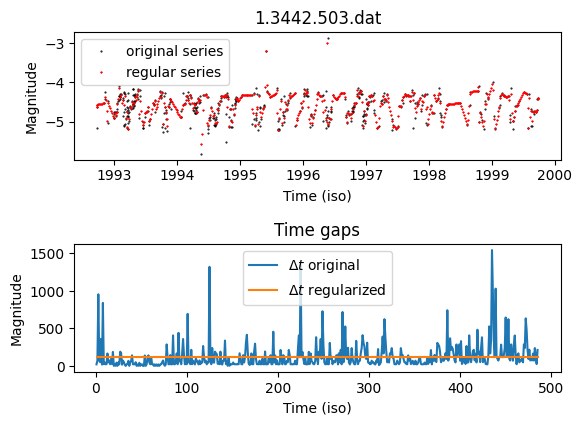

In [55]:
data = objects[paths[794]] #Consideremos esta serie
regular = get_regular_linear_interpolation(data) #esta es su version regular
plot_everything(data, paths[1]) #y aquí está todo ploteado


In [48]:
from astropy.timeseries import LombScargle

def estimate_period(path, plot = False):
    times = objects[path]['mjd'].values
    magnitudes = objects[path]['mag'].values
    frequency, power = LombScargle(times, magnitudes).autopower(method='fastchi2')
    period = 1/frequency[np.argmax(power)] 
    if plot:
        plt.figure(figsize=(5,2))
        plt.plot(frequency, power)
    return period

In [49]:
def get_folded_curve(path, plot = False):
    period = estimate_period(path)
    times = objects[path]['mjd'].values
    magnitudes = objects[path]['mag'].values
    phases = (times%period)/period
    indices = np.argsort(phases)
    values_sorted = magnitudes[indices]
    phases_sorted = phases[indices]
    
    f= interp1d(np.concatenate([phases_sorted, phases_sorted+1]), np.concatenate([values_sorted, values_sorted]))
    regular_curve_phased = np.linspace(min(phases), max(phases), len(phases))

    if plot:
        fig, axes = plt.subplots(3,1, figsize=(8,6))
        fig.tight_layout(pad=4.0)
        axes[0].plot(times, magnitudes)
        axes[1].plot(np.concatenate([phases_sorted, phases_sorted+1]), np.concatenate([values_sorted, values_sorted]))
        axes[0].set_title(path)
        axes[0].set(xlabel="Time (mjd)", ylabel="Magnitude")
        axes[1].set(xlabel="Phase", ylabel="Magnitude")
        axes[1].set_title('Phased ' + path)
        axes[1].set_ylim(-5.8,-4)
        axes[2].set_title('Regular Phased ' + path)
        axes[2].set_ylim(-5.8,-4)
        axes[2].plot(np.concatenate([regular_curve_phased, regular_curve_phased+1]), f(np.concatenate([regular_curve_phased, regular_curve_phased+1])), '*r')
        axes[2].set(xlabel="Phase", ylabel="Magnitude")
        plt.show()
        fig.savefig('books_read.png')
    return phases_sorted, values_sorted, regular_curve_phased, f(regular_curve_phased)

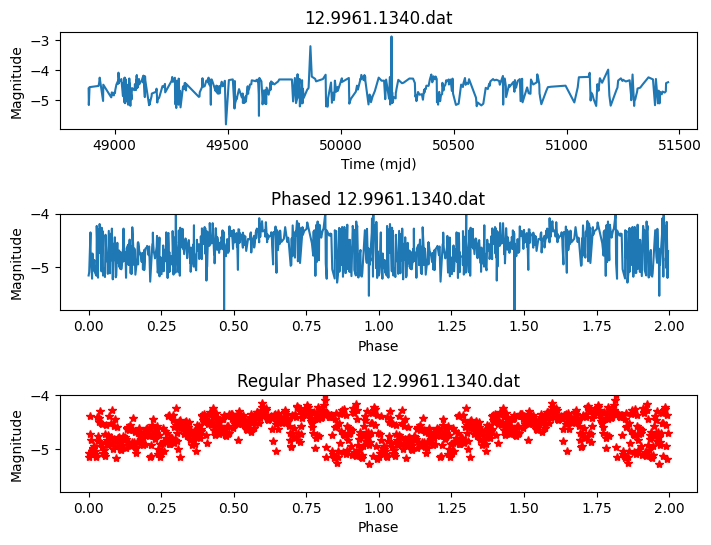

In [56]:
curve_phased, magn_phased, regular_curve_phased, regular_curve_magn = get_folded_curve(paths[794], True)

Ahora vamos a guardar las series regulares, y las series en el diagrama de fases regulares.

In [68]:
objects = dict()
inicio = time.time() #Iniciamos la medición del tiempo d
regular_ts = dict()
phases = dict()
regular_phases = dict()
paths = df['Path']
# tol = 500 #Cambiar aquí por la cantidad de series a guardar
for i in tqdm(range(len(paths))): 
#     if i>= tol:
#         break
    time.sleep(0.001)
    path = paths[i]
    datos = pd.read_csv(gen_path + '/LCs/' + path) #Se leen los datos
    objects[path] = add_iso_time(datos) #Se guarda con la columna iso en objects
    regular = get_regular_linear_interpolation(objects[path]) #la regular que se obtiene por interpolacion
    regular_ts[path] = regular  #se guarda en el diccionario regular_ts
    curve_phased, magn_phased, regular_curve_phased, regular_curve_magn = get_folded_curve(path) #obtenemos en fase, y el fase regular
    phased = pd.DataFrame() 
    phased['phase'] = curve_phased 
    phased['mag'] = magn_phased 
    regular_phased = pd.DataFrame()
    regular_phased['phase'] = regular_curve_phased 
    regular_phased['mag'] = regular_curve_magn 
    phases[path] = phased
    regular_phases[path] = regular_phased #Los guardamos como dataframe en sus reps. diccionarios.
    
#     regular.to_pickle(path + '_regular.pkl') #y los descargamos (los regulares. como pkl)
    regular_phased.to_pickle(path + '_regular_phased.pkl')
    phased.to_pickle(path + '_phased.pkl') #Tambien el fase no regular
    
fin = time.time()
print('Running time: ' + str(fin-inicio) + ' segundos.'+'\n')

  0%|          | 0/7397 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [71]:
#Ahora vamos a cargar los dataframes regulares
regulares = dict()
regular_phases = dict()
# tol = 20
for i in tqdm(range(len(paths))):
#     if i>=tol:
#         break
    time.sleep(0.001)
    path = paths[i]
    datos1 = pd.read_pickle('C:/Users/rauls/OneDrive/DataScience/Proyecto/RRab_regulares/' + path + '_regular.pkl')
    datos2 = pd.read_pickle('C:/Users/rauls/OneDrive/DataScience/' + path + '_regular_phased.pkl')
    regulares[path] = datos1
    regular_phases[path] = datos2

  0%|          | 0/7397 [00:00<?, ?it/s]

In [77]:
#Para cargarlos, por ejemplo 
regular_phases[paths[0]]

,phase,mag
0,0.002815,-5.307000
1,0.006126,-5.170330
2,0.009437,-5.033660
3,0.012748,-5.282510
4,0.016059,-5.415955
...,...,...
297,0.986176,-5.207279
298,0.989487,-5.140611
299,0.992798,-5.430905
300,0.996109,-5.167452


In [78]:
 regulares[paths[0]]

,iso,mag
0,1992-08-07 16:58:07.392000000,-4.694000
1,1992-08-16 15:31:34.139761589,-5.335700
2,1992-08-25 14:05:00.887523178,-5.240068
3,1992-09-03 12:38:27.635284767,-5.144436
4,1992-09-12 11:11:54.383046356,-5.048804
...,...,...
298,1999-11-23 19:04:58.224953522,-4.853976
299,1999-12-02 17:38:24.972715111,-5.061180
300,1999-12-11 16:11:51.720476700,-4.724331
301,1999-12-20 14:45:18.468238289,-4.771399


In [97]:
def plot_everything_phased(path): #esta funcion plotea todo a partir de un dataframe (de la serie no regularizada)
    fig, ax = plt.subplots(2)
    fig.tight_layout(pad=4.0)
    ax[0].set_title(path + ' Regular TS')
#     regular = get_regular_linear_interpolation(data)
    ax[0].plot(regulares[path]['iso'], regulares[path]['mag'], 'r*', markersize=1, label = 'Regular Time series')
#     ax[0].set_title(path)
    ax[0].set(xlabel="Time(iso)", ylabel="Magnitude")
    ax[0].legend()
    
#     delta1 = get_delta_t(data)
#     ax[1].plot(list(range(1, len(data))), get_delta_t(data), label = '$\Delta t$ original')
    ax[1].plot(regular_phases[path]['phase'], regular_phases[path]['mag'], 'k.', markersize=1, label = 'Regular Folded')

#     ax[1].plot(list(range(1, len(regular))), get_delta_t(regular), label = '$\Delta t$ regularized')
    ax[1].set_title(path + ' Folded Regular')
    ax[1].set(xlabel="Phase", ylabel="Magnitude")
    ax[1].legend()
    ax[1].set_ylim(-5.7,-4.5)
    ax[0].set_ylim(-5.7,-4.5)

    plt.savefig('img' + path + '.svg')


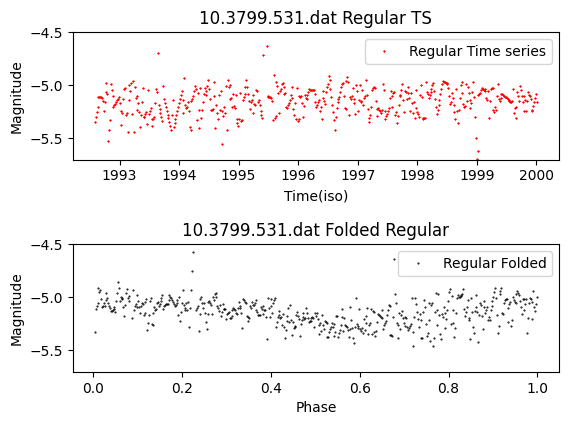

In [98]:
plot_everything_phased(paths[345])